In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
file_path = '/content/drive/My Drive/Merged.json'

df = pd.read_json(file_path,lines=True)

# If "helpful" is a list like [numerator, denominator], split them
df['HelpfulnessNumerator'] = df['helpful'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 0)
df['HelpfulnessDenominator'] = df['helpful'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else 0)
final_columns = [
    'asin',
    'overall',
    'reviewText',
    'reviewTime',
    'reviewerID',
    'reviewerName',
    'summary',
    'unixReviewTime',
    'HelpfulnessNumerator',
    'HelpfulnessDenominator'
]

# Create a new DataFrame with selected and ordered columns
df_final = df[final_columns]
df_final.to_csv('amazon_reviews.csv', index=False, encoding='utf-8')

In [11]:
print(df.columns)
print(df.shape)

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime',
       'HelpfulnessNumerator', 'HelpfulnessDenominator'],
      dtype='object')
(320457, 11)


## Product based CF

In [13]:
count = df.groupby("asin", as_index=False).count()
# Select only numeric columns before applying mean
numeric_cols = df.select_dtypes(include=['number']).columns
mean = df.groupby("asin", as_index=False)[numeric_cols].mean()
dfMerged = pd.merge(df, count, how='right', on=['asin'])
dfMerged

,reviewerID_x,asin,reviewerName_x,helpful_x,reviewText_x,overall_x,summary_x,unixReviewTime_x,reviewTime_x,HelpfulnessNumerator_x,...,reviewerID_y,reviewerName_y,helpful_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y,HelpfulnessNumerator_y,HelpfulnessDenominator_y
0,A10000012B7CGYKOMPQ4L,000100039X,Adam,"[0, 0]",Spiritually and mentally inspiring! A book tha...,5,Wonderful!,1355616000,"12 16, 2012",0,...,206,206,206,206,206,206,206,206,206,206
1,A2S166WSCFIFP5,000100039X,"adead_poet@hotmail.com ""adead_poet@hotmail.com""","[0, 2]",This is one my must have books. It is a master...,5,close to god,1071100800,"12 11, 2003",0,...,206,206,206,206,206,206,206,206,206,206
2,A1BM81XB4QHOA3,000100039X,"Ahoro Blethends ""Seriously""","[0, 0]",This book provides a reflection that you can a...,5,Must Read for Life Afficianados,1390003200,"01 18, 2014",0,...,206,206,206,206,206,206,206,206,206,206
3,A1MOSTXNIO5MPJ,000100039X,Alan Krug,"[0, 0]",I first read THE PROPHET in college back in th...,5,Timeless for every good and bad time in your l...,1317081600,"09 27, 2011",0,...,206,206,206,206,206,206,206,206,206,206
4,A2XQ5LZHTD4AFT,000100039X,Alaturka,"[7, 9]",A timeless classic. It is a very demanding an...,5,A Modern Rumi,1033948800,"10 7, 2002",7,...,206,206,206,206,206,206,206,206,206,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320452,A1YMNTFLNDYQ1F,B00LORXVUE,eyeused2loveher,"[0, 0]",Works great just like my original one. I reall...,5,This works just perfect!,1405900800,"07 21, 2014",0,...,8,8,8,8,8,8,8,8,8,8
320453,A15TX8B2L8B20S,B00LORXVUE,Jon Davidson,"[0, 0]",Great product. Great packaging. High quality a...,5,Great replacement cable. Apple certified,1405900800,"07 21, 2014",0,...,8,8,8,8,8,8,8,8,8,8
320454,A3JI7QRZO1QG8X,B00LORXVUE,Joyce M. Davidson,"[0, 0]","This is a great cable, just as good as the mor...",5,Real quality,1405900800,"07 21, 2014",0,...,8,8,8,8,8,8,8,8,8,8
320455,A1NHB2VC68YQNM,B00LORXVUE,Nurse Farrugia,"[0, 0]",I really like it becasue it works well with my...,5,I really like it becasue it works well with my...,1405814400,"07 20, 2014",0,...,8,8,8,8,8,8,8,8,8,8


In [14]:
#rename column
dfMerged["totalReviewers"] = dfMerged["reviewerID_y"]
dfMerged["overallScore"] = dfMerged["overall_x"]
dfMerged["summaryReview"] = dfMerged["summary_x"]

dfNew = dfMerged[['asin','summaryReview','overallScore',"totalReviewers"]]

Selecting products which have more than 50 reviews.

In [15]:
dfMerged = dfMerged.sort_values(by='totalReviewers', ascending=False)
dfCount = dfMerged[dfMerged.totalReviewers >= 100]
dfCount

,reviewerID_x,asin,reviewerName_x,helpful_x,reviewText_x,overall_x,summary_x,unixReviewTime_x,reviewTime_x,HelpfulnessNumerator_x,...,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y,HelpfulnessNumerator_y,HelpfulnessDenominator_y,totalReviewers,overallScore,summaryReview
40073,AGX6NSQ45FPPJ,0007444117,Suzanne,"[0, 3]","I love the Divergent trilogy. This book, to me...",5,Great!,1388793600,"01 4, 2014",0,...,3821,3821,3821,3821,3821,3821,3821,3821,5,Great!
40072,A12T2WV8V466RD,0007444117,Suzanne Eastman,"[0, 4]",I really enjoyed this trilogy! The factionles...,5,just as good as the first two!,1393804800,"03 3, 2014",0,...,3821,3821,3821,3821,3821,3821,3821,3821,5,just as good as the first two!
40071,A3GQQ1SL6OXAPM,0007444117,Suth,"[6, 13]",Great ending to an enjoyable trilogy. Twists a...,5,perfect ending,1383004800,"10 29, 2013",6,...,3821,3821,3821,3821,3821,3821,3821,3821,5,perfect ending
40070,A1J6E8HFRY2HVJ,0007444117,"Susan W. Nafziger ""Zig""","[0, 3]",I liked how Roth developed the story using the...,4,Whew!,1386547200,"12 9, 2013",0,...,3821,3821,3821,3821,3821,3821,3821,3821,4,Whew!
40069,A1JZGRS68RAQ4Y,0007444117,Susan Rosenberg,"[6, 6]",I was so disappointed in this book for so many...,1,So disappointed.,1389571200,"01 13, 2014",6,...,3821,3821,3821,3821,3821,3821,3821,3821,1,So disappointed.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300555,A3NL4I41MB9E91,B00ENOAYVY,Yollie Brangeliez,"[0, 0]","I am happy to buy it, that I get Exactly for d...",5,Beautiful!!!,1386892800,"12 13, 2013",0,...,100,100,100,100,100,100,100,100,5,Beautiful!!!
300554,A14G8Q2IA8Q9K9,B00ENOAYVY,"W. Levering ""W. Levering""","[0, 0]",This is a great little wallety holder for the ...,5,Perfect Fit - Magnet Warning,1402185600,"06 8, 2014",0,...,100,100,100,100,100,100,100,100,5,Perfect Fit - Magnet Warning
300545,A3GZ1OQNKIOX6L,B00ENOAYVY,"Sherry R. Melancon ""sherlock_""","[6, 10]",Edit 2: I have been contacted by customer ser...,3,Read this before purchasing for a Note 3,1381363200,"10 10, 2013",6,...,100,100,100,100,100,100,100,100,3,Read this before purchasing for a Note 3
300544,A3N9GUKOLL61YK,B00ENOAYVY,sharon,"[0, 0]","I love this cases, only wish it had a belt cli...",5,Great cellto!,1385769600,"11 30, 2013",0,...,100,100,100,100,100,100,100,100,5,Great cellto!


## Grouping all the summary Reviews by product ID

In [18]:
numeric_cols = df.select_dtypes(include=['number']).columns
dfProductReview = df.groupby("asin", as_index=False)[numeric_cols].mean()
ProductReviewSummary = dfCount.groupby("asin")["summaryReview"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.to_csv("ProductReviewSummary.csv")

In [19]:
dfProductReview

,asin,overall,unixReviewTime,HelpfulnessNumerator,HelpfulnessDenominator
0,000100039X,4.674757,1.236713e+09,4.883495,6.883495
1,0001055178,3.555556,1.031966e+09,2.944444,3.833333
2,0001473123,4.625000,1.349109e+09,0.750000,0.937500
3,0001473727,5.000000,1.356048e+09,1.000000,1.000000
4,0001473905,4.666667,1.332288e+09,0.833333,0.833333
...,...,...,...,...,...
13836,B00LH1QZR8,5.000000,1.405797e+09,0.000000,0.000000
13837,B00LH1R3C4,5.000000,1.405642e+09,0.000000,0.000000
13838,B00LH1R5HW,5.000000,1.405659e+09,0.000000,0.000000
13839,B00LH1R6SK,5.000000,1.405642e+09,0.000000,0.000000


## Creating dataframe with certain columns

In [20]:
df3 = pd.read_csv("ProductReviewSummary.csv")
df3 = pd.merge(df3, dfProductReview, on="asin", how='inner')

In [21]:
df3 = df3[['asin','summaryReview','overall']]

## Text Cleaning - Summary column

In [22]:
#function for tokenizing summary
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

In [23]:
#reset index and drop duplicate rows
df3["summaryClean"] = df3["summaryReview"].apply(cleanReviews)
df3 = df3.drop_duplicates(['overall'], keep='last')
df3 = df3.reset_index()

In [26]:
reviews = df3["summaryClean"]
countVector = CountVectorizer(max_features = 300, stop_words='english')
transformedReviews = countVector.fit_transform(reviews)

dfReviews = DataFrame(transformedReviews.toarray(), columns=countVector.get_feature_names_out())
dfReviews = dfReviews.astype(int)

In [27]:
#save
dfReviews.to_csv("dfReviews.csv")

In [28]:
# First let's create a dataset called X
X = np.array(dfReviews)
 # create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [29]:
# KNN classifier to find similar products
print(lentrain)
print(lentest)

378
43


In [30]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [32]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = np.array(first_related_product).item()  # Convert to Python int
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = np.array(second_related_product).item()  # Convert to Python int

    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B00AYNRLFA  average rating is  3.9574468085106385
The first similar product is  B005WUH9X4  average rating is  3.59375
The second similar product is  B005T0DTOU  average rating is  3.8378378378378377
-----------------------------------------------------------
Based on product reviews, for  B00B7QGT6U  average rating is  4.298429319371728
The first similar product is  B00AOW8I30  average rating is  3.9005524861878453
The second similar product is  B0093IHVJI  average rating is  4.171673819742489
-----------------------------------------------------------
Based on product reviews, for  B00B8M4IMK  average rating is  4.693486590038314
The first similar product is  B00845NI8E  average rating is  4.528205128205128
The second similar product is  B009HD44US  average rating is  4.655737704918033
-----------------------------------------------------------
Based on product reviews, for  B00B8MMZY8  average rating is  4.175438596491228
The first similar product is  

In [33]:
print ("Based on product reviews, for ", df3["asin"][260] ," average rating is ",df3["overall"][260])
print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
print ("-----------------------------------------------------------")

Based on product reviews, for  B005AOKW8Q  average rating is  4.232472324723247
The first similar product is  B008ALV0V4  average rating is  4.384
The second similar product is  B00687N0GK  average rating is  3.6554621848739495
-----------------------------------------------------------


## Predicting Review Score

In [34]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.67      0.67      0.67         6
           4       0.95      0.95      0.95        37

    accuracy                           0.91        43
   macro avg       0.81      0.81      0.81        43
weighted avg       0.91      0.91      0.91        43



## Accuracy of the model

In [35]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.9069767441860465


In [36]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.09302325581395349


## Predicting Review Score with k = 5

In [37]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.75      0.50      0.60         6
           4       0.92      0.97      0.95        37

    accuracy                           0.91        43
   macro avg       0.84      0.74      0.77        43
weighted avg       0.90      0.91      0.90        43



In [38]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.9069767441860465


In [39]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.09302325581395349


## Predicting reviews with 85, 15 train, test split and k = 5

In [40]:
# First let's create a dataset called X
X = np.array(dfReviews)
 # create train and test
tpercent = 0.85
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [41]:
# Next we will instantiate a nearest neighbor object, and call it nbrs. Then we will fit it to dataset X.
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [43]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = np.array(first_related_product).item()  # Convert to Python int
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = np.array(second_related_product).item()  # Convert to Python int

    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B009N5OX2E  average rating is  4.18848167539267
The first similar product is  B0098T62GA  average rating is  4.203592814371257
The second similar product is  B008B85DNC  average rating is  4.460431654676259
-----------------------------------------------------------
Based on product reviews, for  B009NLTW60  average rating is  4.538461538461538
The first similar product is  B004CLYJ2I  average rating is  3.824561403508772
The second similar product is  B0099RGRT8  average rating is  4.3924050632911396
-----------------------------------------------------------
Based on product reviews, for  B009QUDLC4  average rating is  4.108527131782946
The first similar product is  B0092QSQ3Q  average rating is  3.8392857142857144
The second similar product is  B0085BD0Z8  average rating is  4.067796610169491
-----------------------------------------------------------
Based on product reviews, for  B009RXU59C  average rating is  4.676100628930818
The first similar prod

In [44]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.62      0.50      0.56        10
           4       0.91      0.94      0.93        54

    accuracy                           0.88        64
   macro avg       0.77      0.72      0.74        64
weighted avg       0.87      0.88      0.87        64



In [45]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.875


In [46]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.125


## kNN with k = 3, Algorithm = Brute

In [47]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(dfReviews_train)

distances, indices = neighbor.kneighbors(dfReviews_train)

In [48]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.42      0.50      0.45        10
           4       0.90      0.87      0.89        54

    accuracy                           0.81        64
   macro avg       0.66      0.69      0.67        64
weighted avg       0.83      0.81      0.82        64

Accuracy:  0.8125
MSE:  0.1875


## kNN with k= 5, and Algorithm = KD_Tree

In [49]:
neighbor = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(dfReviews_train)
distances, indices = neighbor.kneighbors(dfReviews_train)

In [50]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.62      0.50      0.56        10
           4       0.91      0.94      0.93        54

    accuracy                           0.88        64
   macro avg       0.77      0.72      0.74        64
weighted avg       0.87      0.88      0.87        64

Accuracy:  0.875
MSE:  0.125


## Word correltation based on cluster

In [51]:
cluster = df.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanReviews)

## World Clouding for Each Score Group

In [52]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

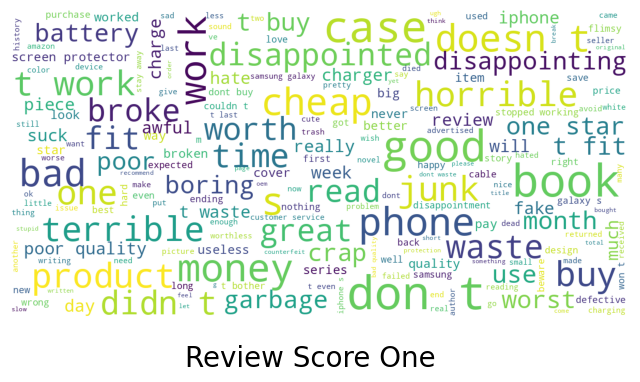

In [53]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

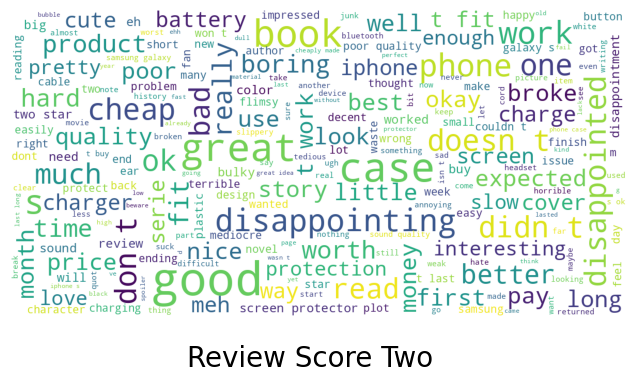

In [54]:
show_wordcloud(cluster1["summaryClean"][1] , title = "Review Score Two")

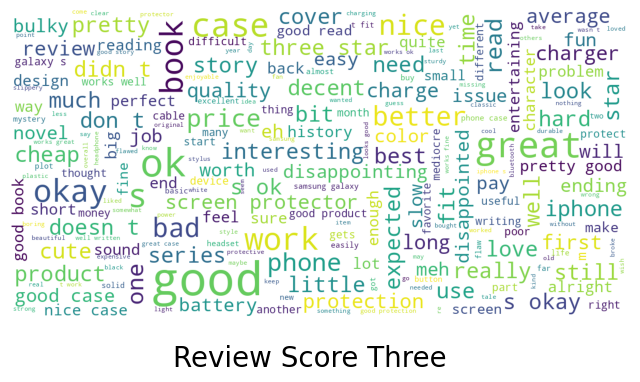

In [55]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Score Three")

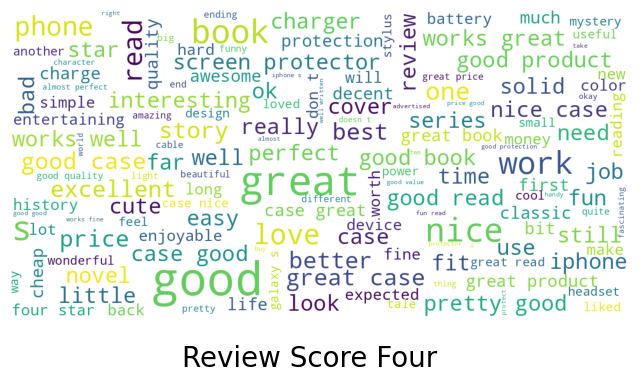

In [56]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Score Four")

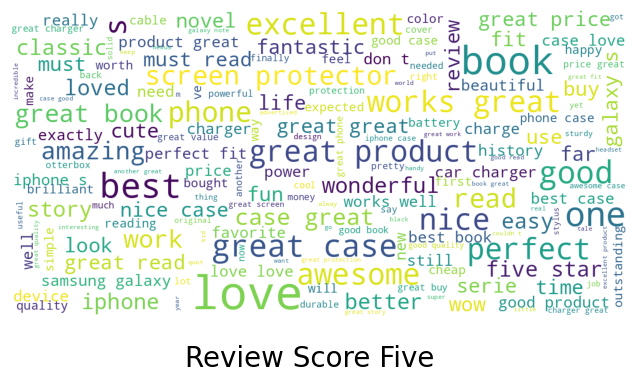

In [57]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Score Five")

Rights: Vindhya V